# Fidelity-based quality assessment

Author:  Daniel Proaño-Guevara

PRODEB

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle

import preprocessing_lib as pplib
import feature_extraction_lib as ftelib

## Initial signals with their segmentation-delineation

### Phonocardiography (PCG)

ULSGE Dataset

In [2]:
root_dir = r'..\DatasetCHVNGE\pcg_ulsge.pkl'
df = pd.read_pickle(root_dir)
# Resample them to 50 Hz
df['Signal'] = df['Signal'].apply(
    lambda data: pplib.downsample(data, 3000, 50))

# Import Predictions
pred_path = r'..\ULSGE_pred_butter.pkl'
with open(pred_path, 'rb') as file:
    predictions = pickle.load(file)

### Show Raw Predictions

C:\Users\danie\AppData\Local\Temp\ipykernel_30432\3557005574.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(pplib.min_max_norm2(df.iloc[63][2])[300:700], label = 'PCG raw')


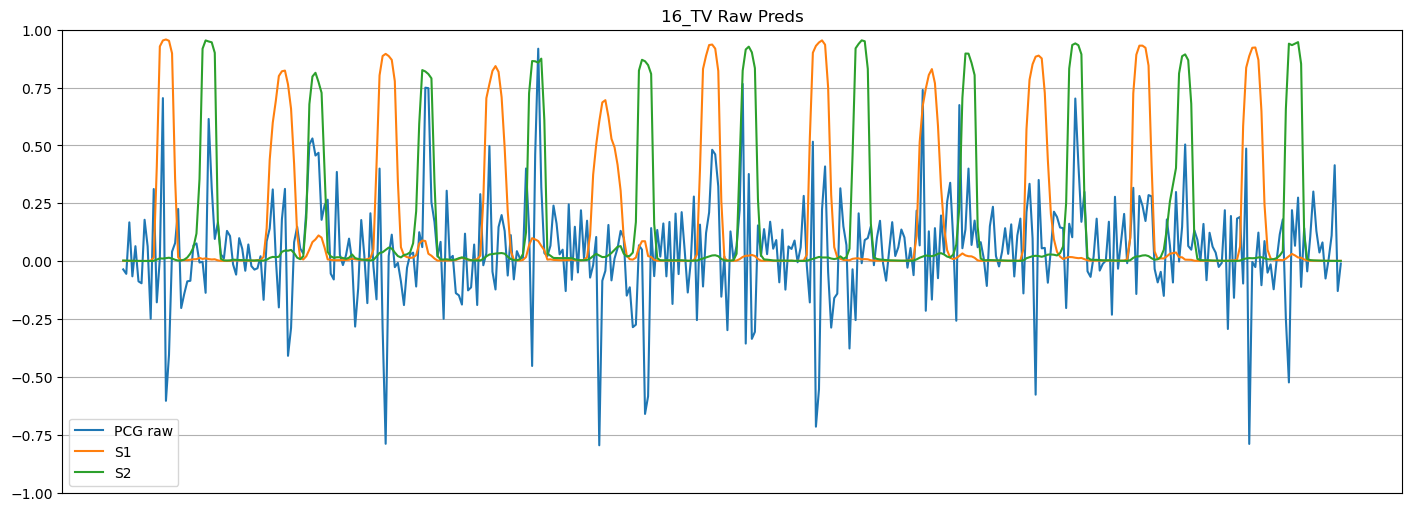

In [3]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Raw Preds')
plt.plot(pplib.min_max_norm2(df.iloc[63][2])[300:700], label = 'PCG raw')
plt.plot(predictions[63][300:700, 0], label='S1')
plt.plot(predictions[63][300:700, 2], label='S2')
plt.xticks([])
plt.ylim(-1, 1)
plt.legend(loc=3)
plt.grid()
plt.show()

### Smooth Predictions

In [4]:
AVERAGE_WINDOW = 3
processed_predictions = [
    np.column_stack([pplib.moving_average(data[:, i], AVERAGE_WINDOW) for i in range(4)])
    for data in predictions
]

C:\Users\danie\AppData\Local\Temp\ipykernel_30432\255384594.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(pplib.min_max_norm2(df.iloc[63][2])[300:700], label = 'PCG raw')


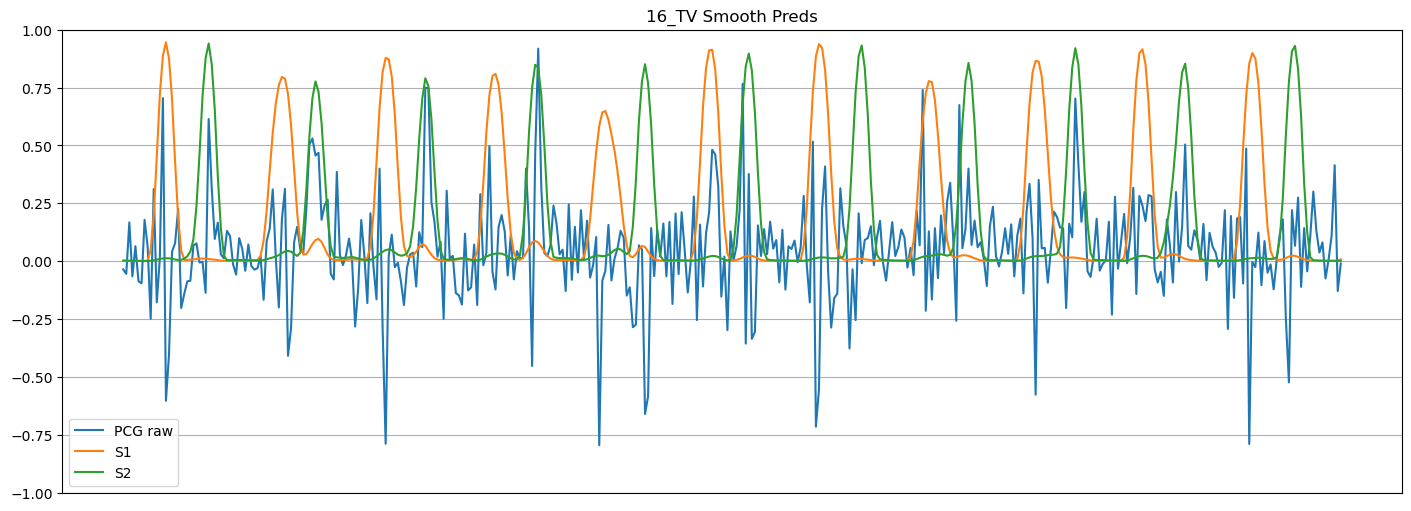

In [5]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Smooth Preds')
plt.plot(pplib.min_max_norm2(df.iloc[63][2])[300:700], label = 'PCG raw')
plt.plot(processed_predictions[63][300:700, 0], label='S1')
plt.plot(processed_predictions[63][300:700, 2], label='S2')
plt.xticks([])
plt.ylim(-1, 1)
plt.legend(loc=3)
plt.grid()
plt.show()

### Reverse One-hot encoding

In [6]:
pred_labels = [ftelib.reverse_one_hot_encoding(pred) for pred in processed_predictions]
prediction_labels = copy.deepcopy(pred_labels)
state_predictions = np.array([prediction for prediction in prediction_labels], dtype=object)

C:\Users\danie\AppData\Local\Temp\ipykernel_30432\1827317315.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot((pplib.min_max_norm2(df.iloc[63][2])*2 +1)[300:700], label = 'PCG raw')


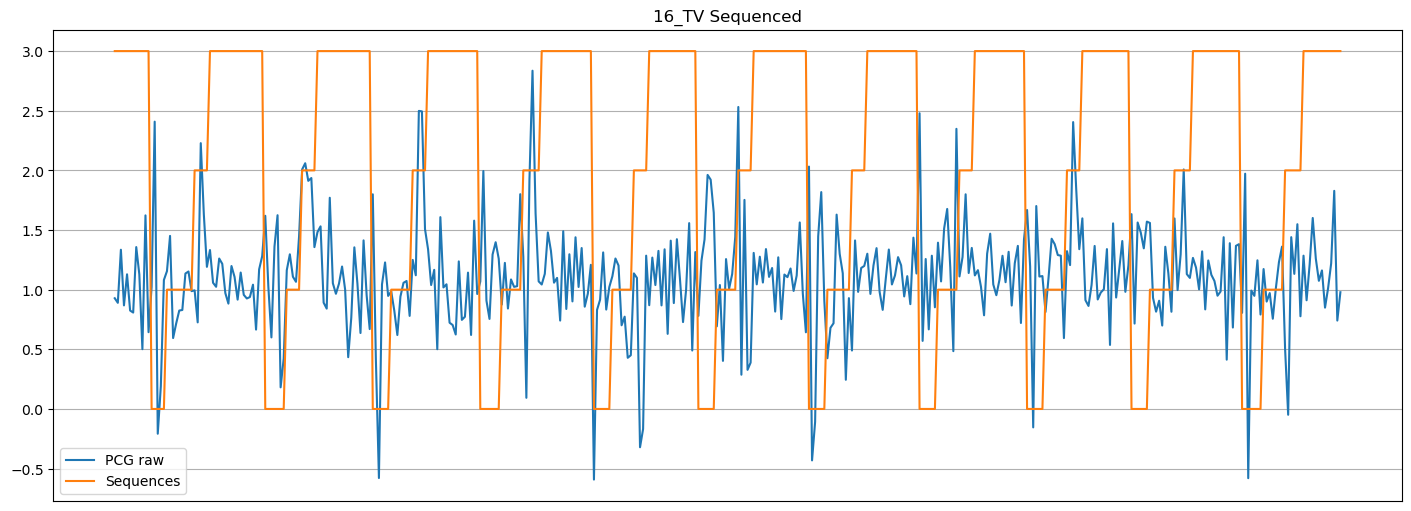

In [7]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Sequenced')
plt.plot((pplib.min_max_norm2(df.iloc[63][2])*2 +1)[300:700], label = 'PCG raw')
plt.plot(state_predictions[63][300:700], label='Sequences')
plt.xticks([])
#plt.ylim(-1, 1)
plt.legend(loc=3)
plt.grid()
plt.show()

## Electrocardiography (ECG)